In [1]:
import os
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import processing

%matplotlib inline

### DataFrame mapy Europy

In [2]:
europe = gpd.read_file('europe.geojson')
europe.head()

,continent,name,iso_a2,geometry
0,Europe,Norway,NO,"POLYGON ((31.10104 69.55810, 29.39955 69.15692..."
1,Europe,France,FR,"POLYGON ((6.18632 49.46380, 6.65823 49.20196, ..."
2,Europe,Sweden,SE,"POLYGON ((11.02737 58.85615, 11.46827 59.43239..."
3,Europe,Belarus,BY,"POLYGON ((28.17671 56.16913, 29.22951 55.91834..."
4,Europe,Ukraine,UA,"POLYGON ((31.78599 52.10168, 32.15944 52.06125..."


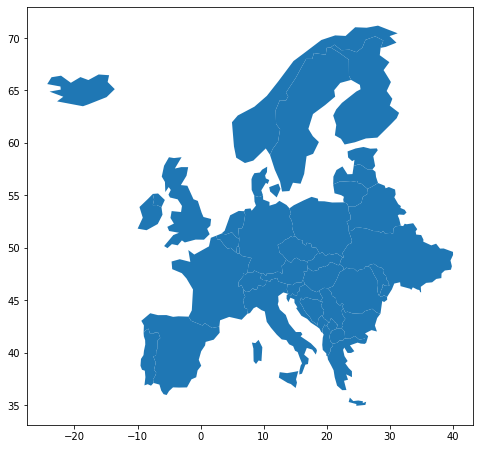

In [3]:
europe.plot(figsize=(8,8))
plt.show()

### Dodawanie cech utworów charakterystycznych dla państw

In [4]:
track_features_names = [
    'danceability',
    'key',
    'acousticness',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
]

In [5]:
categorical_features_names = ['key', 'key_2', 'time_signature', 'time_signature_2']

In [6]:
df_charts = processing.get_charts()
df_tracks = processing.get_tracks_with_genres()
DF_TRACKS = df_charts.merge(df_tracks, left_on='track_id', right_index=True)

In [7]:
DF_TRACKS.head()

,country_code,date,chart_id,position,track_id,n_streams,title,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
id,,,,,,,,,,,,,,,,,,,,,
1,ae,2018-11-16,2,1,2rPE9A1vEgShuZxxzR2tZH,17489,"thank u, next",0.724,0.647,1.0,...,1.0,0.0658,0.28,0.0,0.102,0.435,106.96,207333.0,4.0,"[dance pop, pop]"
201,ae,2018-11-23,3,1,2rPE9A1vEgShuZxxzR2tZH,12822,"thank u, next",0.724,0.647,1.0,...,1.0,0.0658,0.28,0.0,0.102,0.435,106.96,207333.0,4.0,"[dance pop, pop]"
401,ae,2018-11-30,4,1,2rPE9A1vEgShuZxxzR2tZH,16148,"thank u, next",0.724,0.647,1.0,...,1.0,0.0658,0.28,0.0,0.102,0.435,106.96,207333.0,4.0,"[dance pop, pop]"
601,ae,2018-12-07,5,1,2rPE9A1vEgShuZxxzR2tZH,15740,"thank u, next",0.724,0.647,1.0,...,1.0,0.0658,0.28,0.0,0.102,0.435,106.96,207333.0,4.0,"[dance pop, pop]"
801,ae,2018-12-14,6,1,2rPE9A1vEgShuZxxzR2tZH,15741,"thank u, next",0.724,0.647,1.0,...,1.0,0.0658,0.28,0.0,0.102,0.435,106.96,207333.0,4.0,"[dance pop, pop]"


In [8]:
def fill_mean_country_features(gdf: gpd.GeoDataFrame, country: str):
    features = DF_TRACKS[DF_TRACKS['country_code'] == country.lower()]
    if features.empty:
        return
    
    gdf.loc[europe.iso_a2 == country, 'danceability'] = features['danceability'].mean()
    gdf.loc[europe.iso_a2 == country, 'key'] = features['key'].mode()[0]
    key_1 = features['key'].mode()[0]
    key_2 = features[features.key != key_1]['key'].mode()[0]
    gdf.loc[europe.iso_a2 == country, 'key'] = key_1
    gdf.loc[europe.iso_a2 == country, 'key_2'] = key_2
    gdf.loc[europe.iso_a2 == country, 'acousticness'] = features['acousticness'].mean()
    gdf.loc[europe.iso_a2 == country, 'loudness'] = features['loudness'].mean()
    gdf.loc[europe.iso_a2 == country, 'mode'] = features['mode'].mean()
    gdf.loc[europe.iso_a2 == country, 'speechiness'] = features['speechiness'].mean()
    gdf.loc[europe.iso_a2 == country, 'acousticness'] = features['acousticness'].mean()
    gdf.loc[europe.iso_a2 == country, 'instrumentalness'] = features['instrumentalness'].mean()
    gdf.loc[europe.iso_a2 == country, 'liveness'] = features['liveness'].mean()
    gdf.loc[europe.iso_a2 == country, 'valence'] = features['valence'].mean()
    gdf.loc[europe.iso_a2 == country, 'tempo'] = features['tempo'].mean()
    gdf.loc[europe.iso_a2 == country, 'duration_ms'] = features['duration_ms'].mean()
    time_signature_1 = features['time_signature'].mode()[0]
    time_signature_2 = features[features.time_signature != time_signature_1]['time_signature'].mode()[0]
    gdf.loc[europe.iso_a2 == country, 'time_signature'] = time_signature_1
    gdf.loc[europe.iso_a2 == country, 'time_signature_2'] = time_signature_2

In [9]:
def fill_variance_country_features(gdf: gpd.GeoDataFrame, country: str):
    features = DF_TRACKS[DF_TRACKS['country_code'] == country.lower()]
    if features.empty:
        return
    
    for f_name in track_features_names:
        norm_std_dev = features[f_name].std() / features[f_name].mean()
        gdf.loc[europe.iso_a2 == country, f'{f_name}_variance'] = norm_std_dev

In [10]:
def fill_most_popular_genre(gdf: gpd.GeoDataFrame, country: str):
    features = DF_TRACKS[DF_TRACKS['country_code'] == country.lower()]
    if features.empty:
        return
    
    genres = []
    for g in features['genres']:
        genres.extend(g)
    gdf.loc[europe.iso_a2 == country, 'mpg'] = pd.Series(genres).mode()[0]

In [11]:
for country in europe['iso_a2']:
    fill_mean_country_features(europe, country)
    fill_variance_country_features(europe, country)
    fill_most_popular_genre(europe, country)

In [12]:
europe.head()

,continent,name,iso_a2,geometry,danceability,key,key_2,acousticness,loudness,mode,...,loudness_variance,mode_variance,speechiness_variance,instrumentalness_variance,liveness_variance,valence_variance,tempo_variance,duration_ms_variance,time_signature_variance,mpg
0,Europe,Norway,NO,"POLYGON ((31.10104 69.55810, 29.39955 69.15692...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Europe,France,FR,"POLYGON ((6.18632 49.46380, 6.65823 49.20196, ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Europe,Sweden,SE,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Europe,Belarus,BY,"POLYGON ((28.17671 56.16913, 29.22951 55.91834...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Europe,Ukraine,UA,"POLYGON ((31.78599 52.10168, 32.15944 52.06125...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analiza cech kategorycznych 

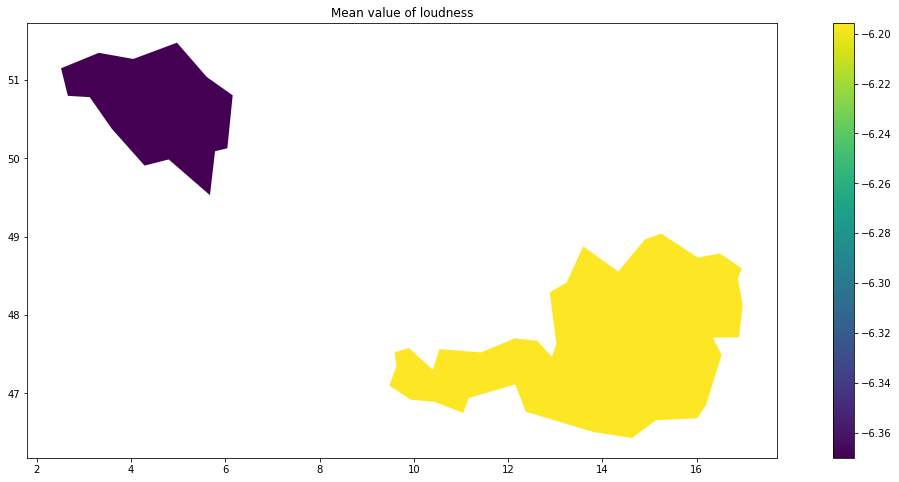

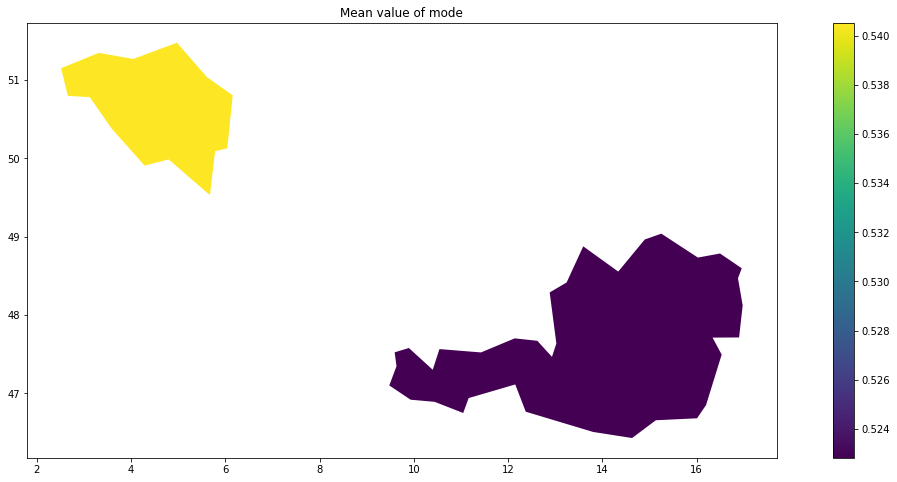

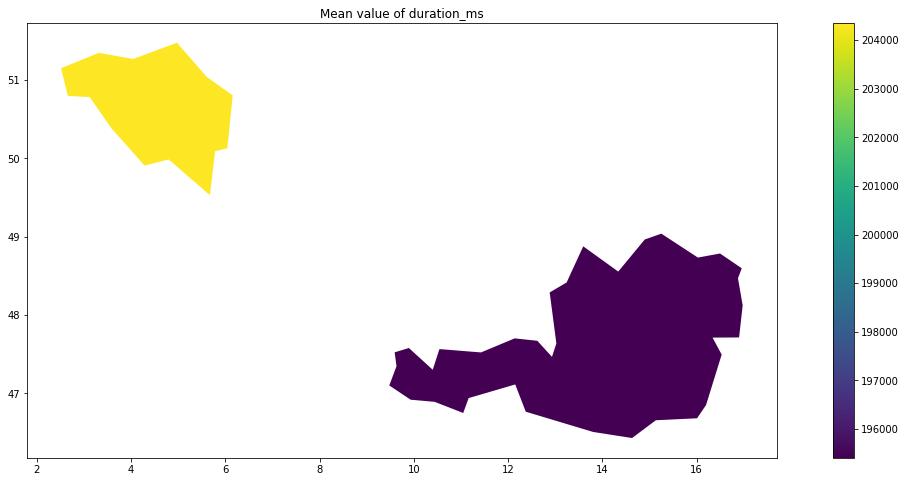

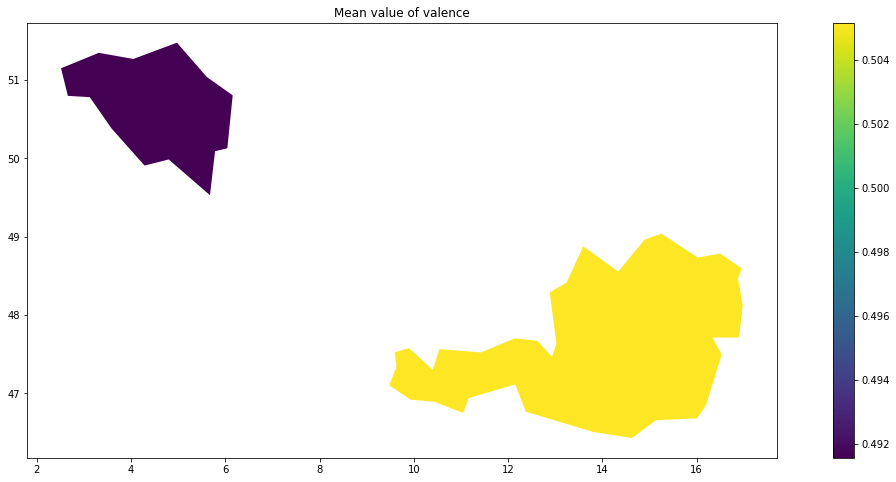

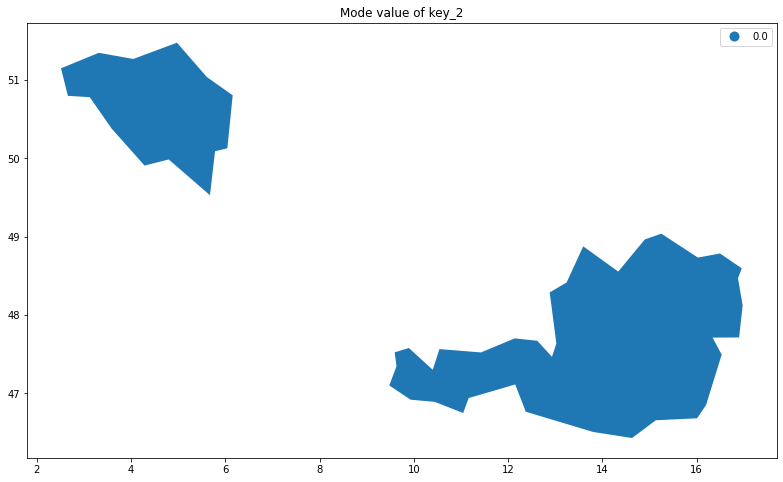

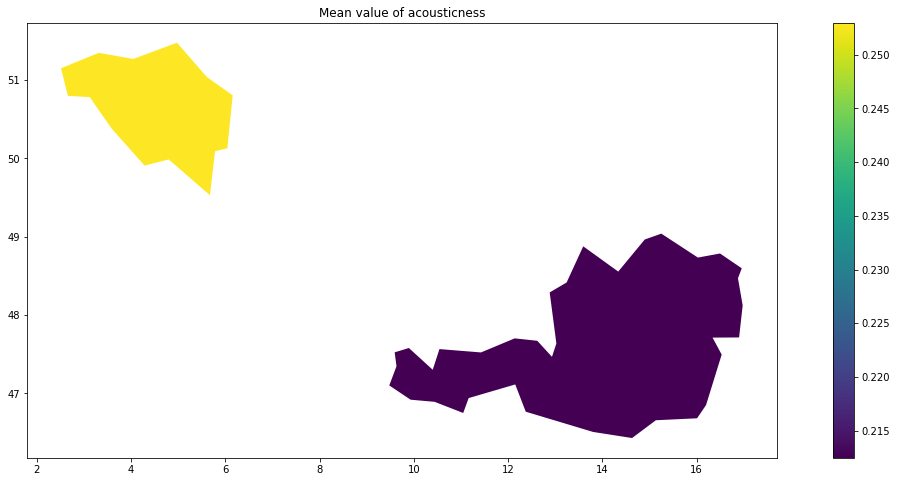

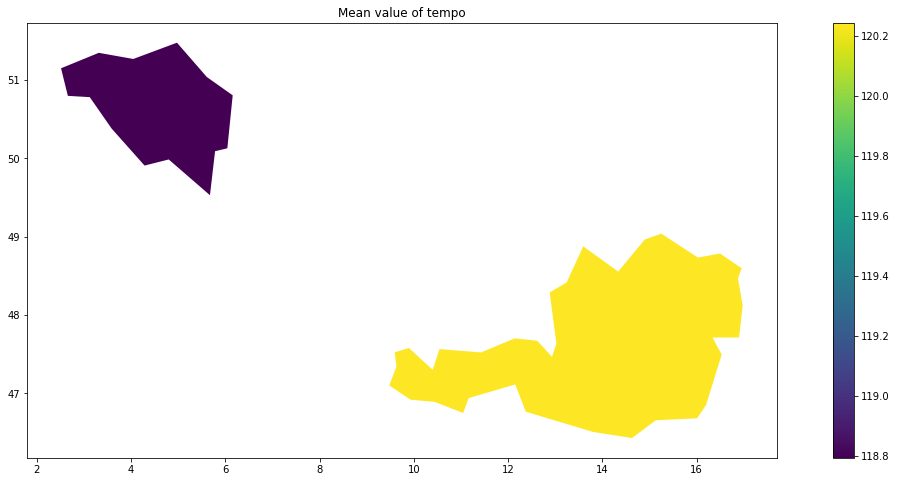

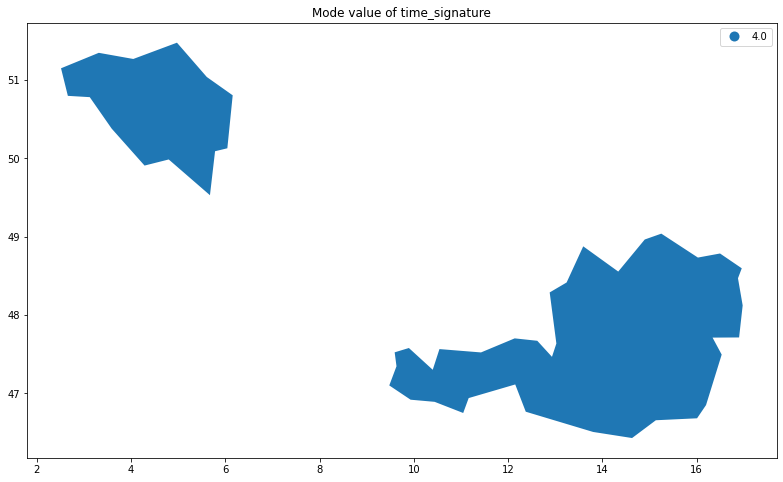

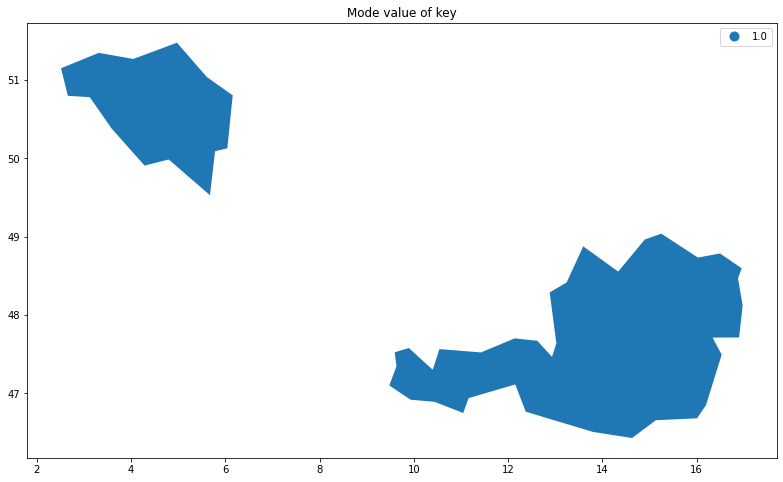

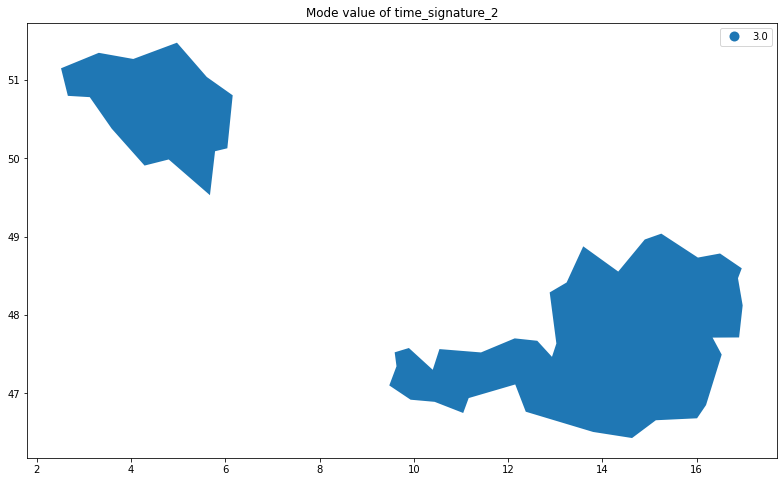

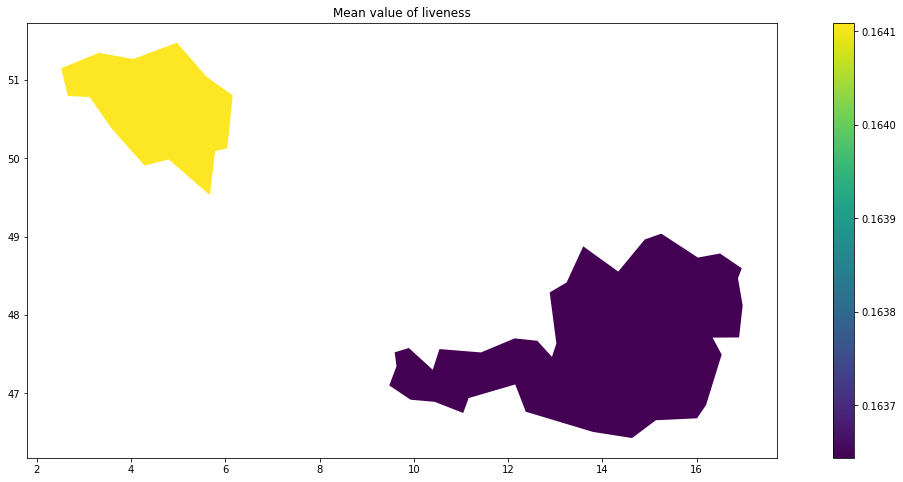

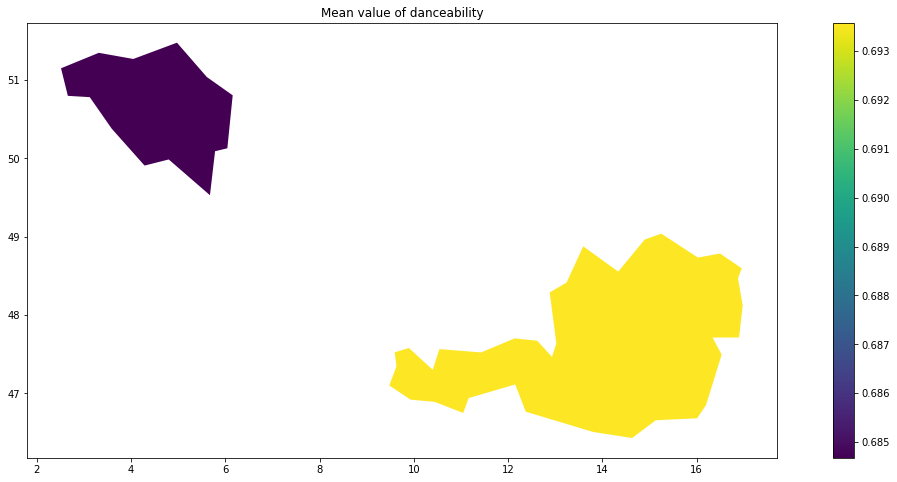

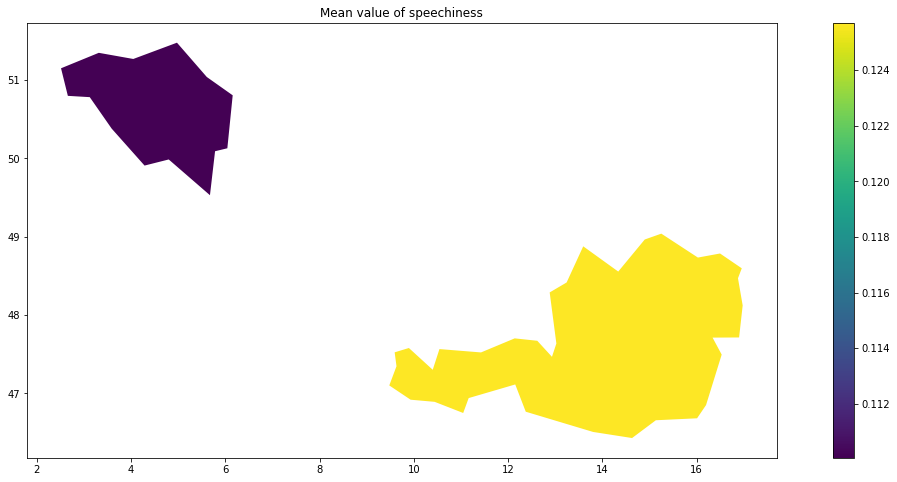

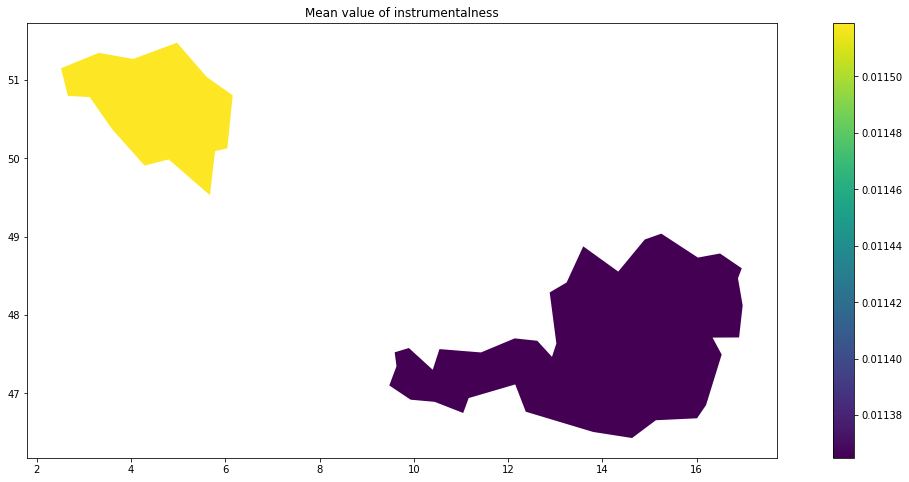

In [13]:
for feature_name in set(track_features_names + categorical_features_names):
    categorical = feature_name in categorical_features_names
    prefix = 'Mode' if categorical else 'Mean'
    europe.plot(figsize=(20,8), column=feature_name, legend=True, categorical=categorical)
    plt.title(f'{prefix} value of {feature_name}')
    plt.show()

### Wnioski
Cechy kategoryczne nie różnią się w zależności od kraju - tendencje są takie same. Ze względu na ich charakter semantyczny nie wydają się sensowną informacją w kontekście rekomendacji.
Cechy które dają niewielkie rozróżnienie w zależności od kraju to: liveness, loudness, tempo, instrumentalness, acousticness. Prawdopodobnie nie będzie warto specjalnie ich traktować w zależności od kraju w którym zarejestrowany jest użytkownik.
Cechy które w interesujący sposób różnią się w zależności od kraju to: duration_ms, mode, speechiness, valence, danceability. Dla nich będzie można eksperymentować z lokalizacją użytkownika.

### Analiza cech ciągłych

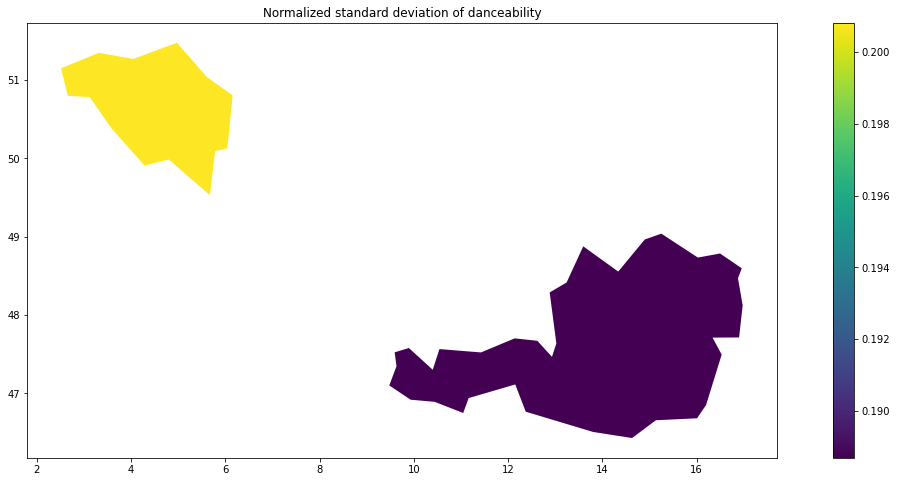

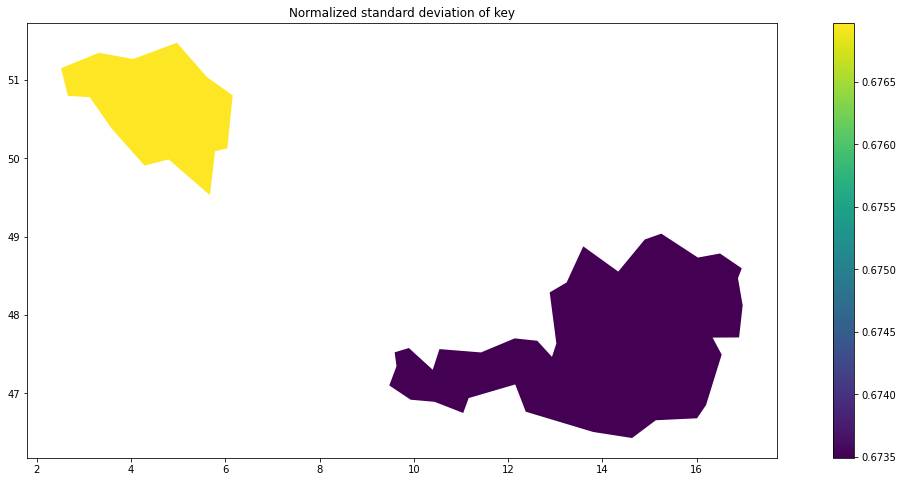

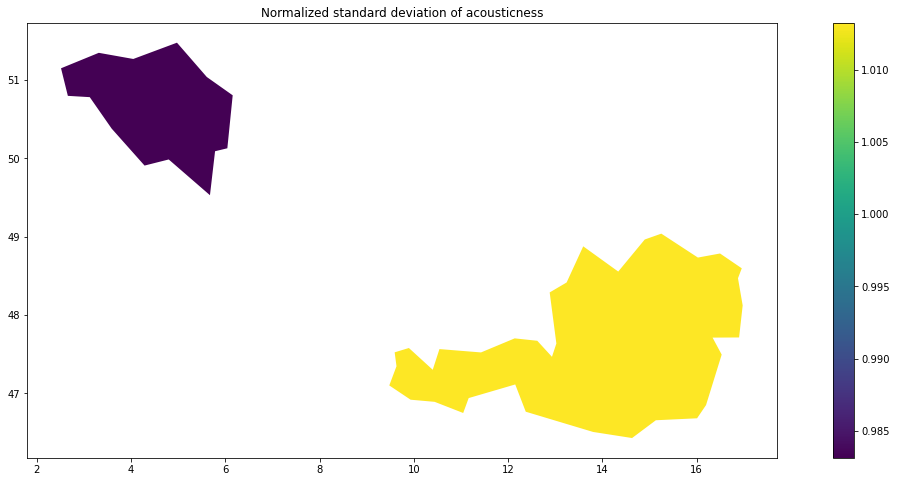

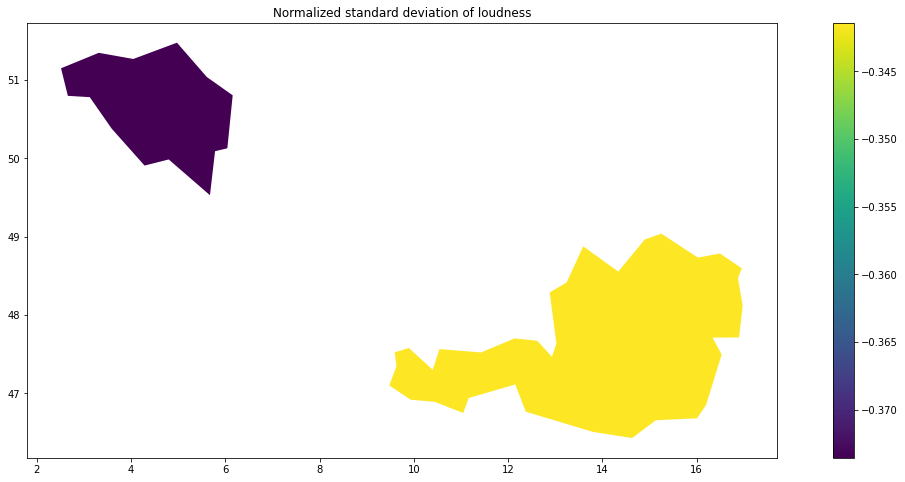

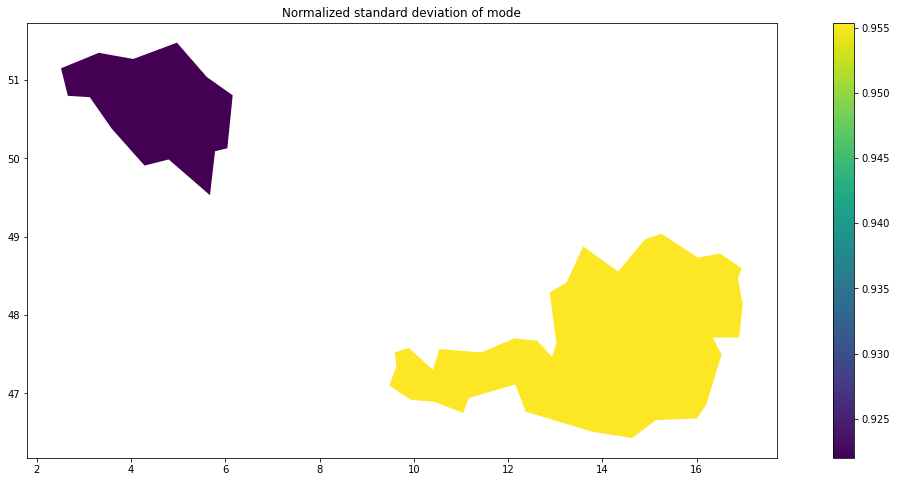

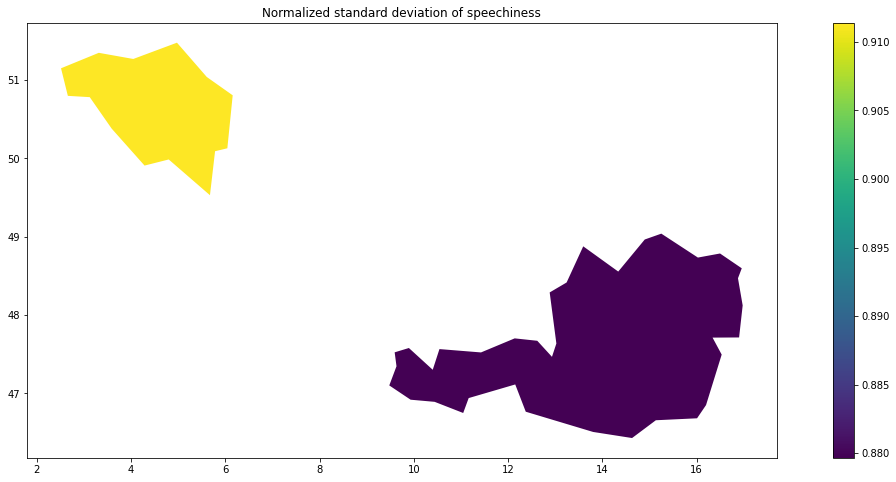

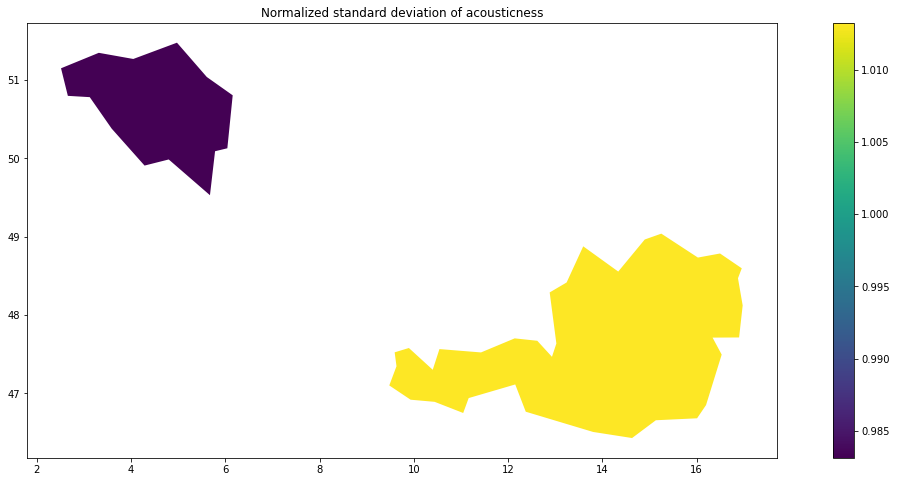

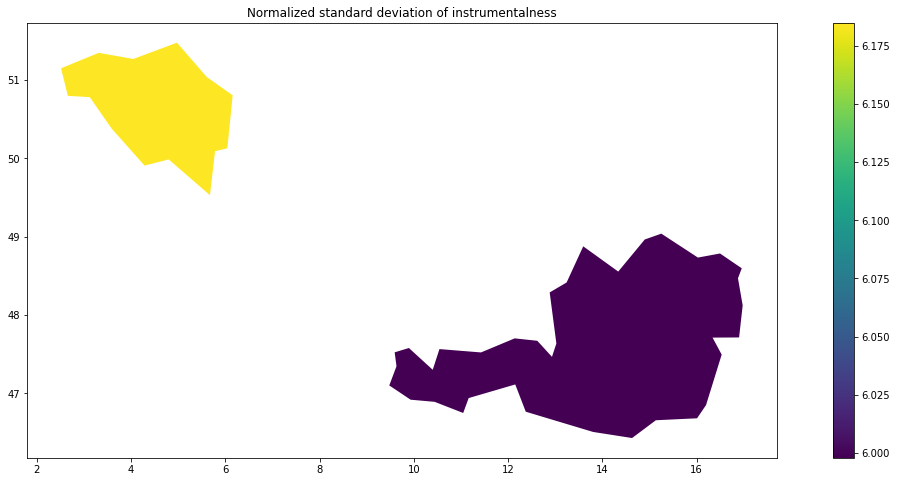

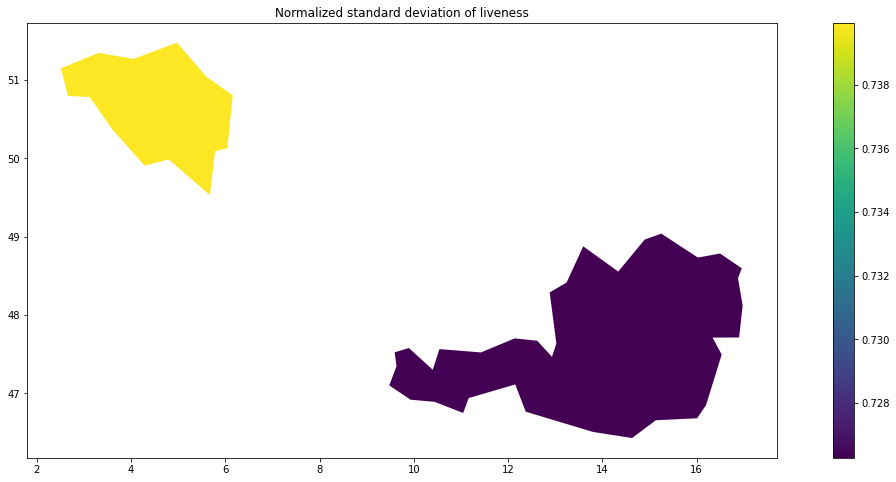

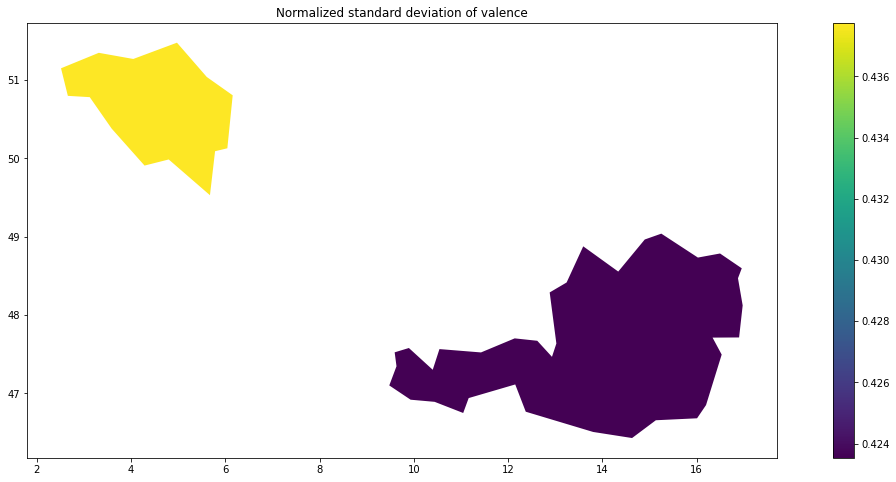

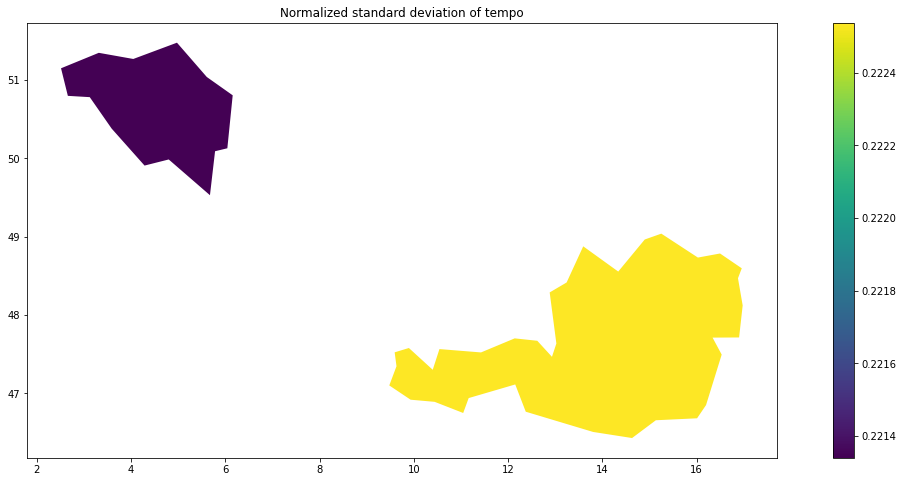

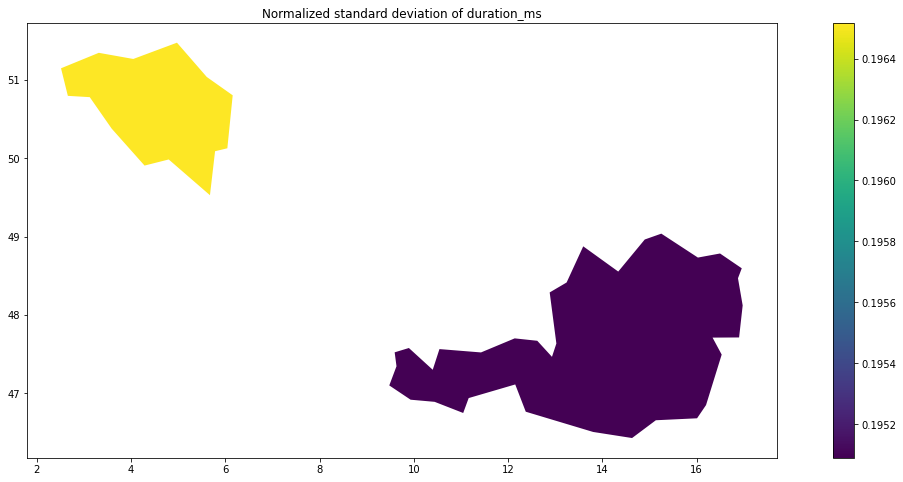

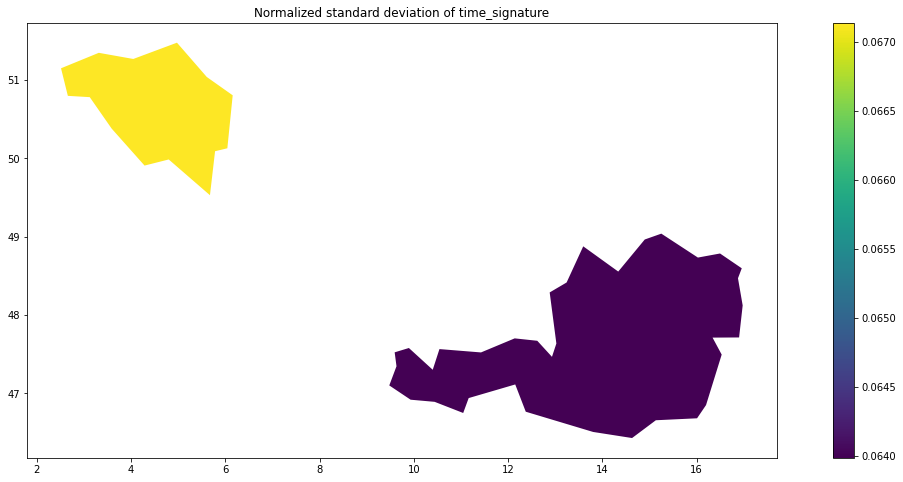

In [14]:
for feature_name in track_features_names:
    europe.plot(figsize=(20,8), column=f'{feature_name}_variance', legend=True)
    plt.title(f'Normalized standard deviation of {feature_name}')
    plt.show()

### Wnioski
Cechy o niskim odchyleniu standardowym to: danceability, loudness, valence, tempo, duration_ms, time_signature. Można stwierdzić, że są istotnym czynnikiem wpływającym na znalezienie się utworu na liście przebojów. Prawdopodobnie będą odgrywały też kluczową rolę w systemie rekomendacyjnym.
Cechy o dużym odchyleniu standardowym to: acousticness, mode, instrumentalness. Mają one mały wpływ na popularność utworów. W dalszych pracach będzie warto rozważyć, czy wniosą one coś do systemu rekomendacyjnego, czy też warto z nich zrezygnować i otrzymać prostszy model.

### Analiza najpopularniejszych gatunków

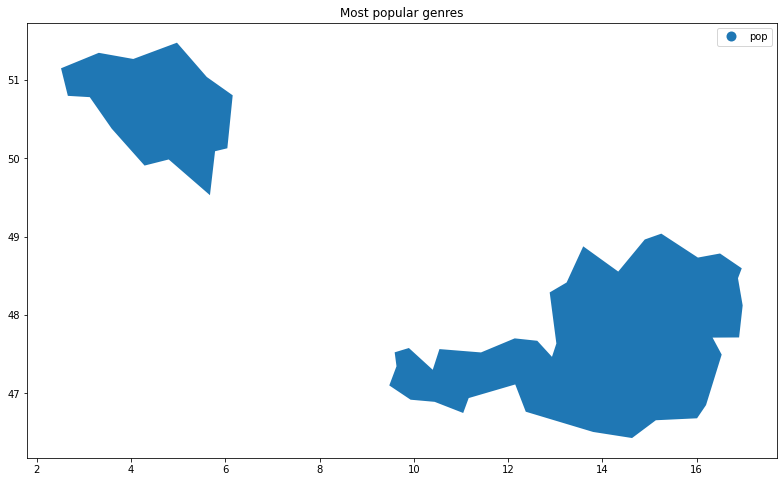

In [15]:
europe.plot(figsize=(20,8), column='mpg', legend=True)
plt.title(f'Most popular genres')
plt.show()